# Sales Predictor

### IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### DATA COLLECTION AND ANALYSIS

In [2]:
df=pd.read_csv('Advertising.csv')

In [3]:
df.head(10)

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
5,6,8.7,48.9,75.0,7.2
6,7,57.5,32.8,23.5,11.8
7,8,120.2,19.6,11.6,13.2
8,9,8.6,2.1,1.0,4.8
9,10,199.8,2.6,21.2,10.6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [5]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    # sum['value_counts']=train.value_counts()
    # sum['skew'] = train.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(df).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,min,max,mean
Unnamed: 0,int64,0,0.000000,200,200,1.000000,200.000000,100.500000
TV,float64,0,0.000000,190,200,0.700000,296.400000,147.042500
Radio,float64,0,0.000000,167,200,0.000000,49.600000,23.264000
Newspaper,float64,0,0.000000,172,200,0.300000,114.000000,30.554000
Sales,float64,0,0.000000,121,200,1.600000,27.000000,14.022500


In [6]:
df.duplicated().sum()

0

In [7]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [8]:
df.columns

Index(['TV', 'Radio', 'Newspaper', 'Sales'], dtype='object')

# **DATA VISUALIZATION**

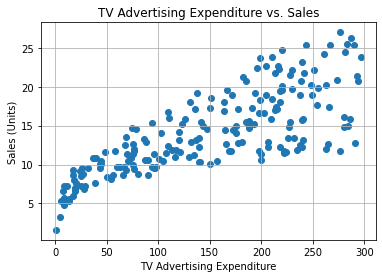

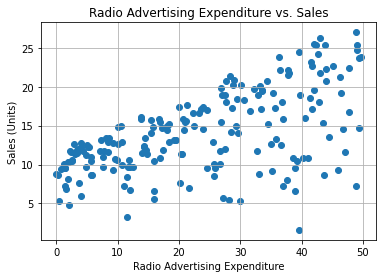

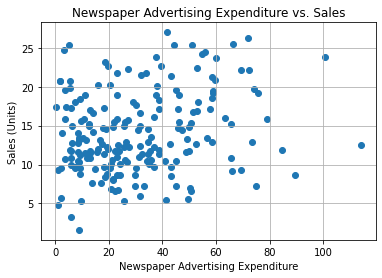

In [9]:

for col in df.columns[:-1]:  
    plt.scatter(df[col], df['Sales'])
    plt.xlabel(f'{col} Advertising Expenditure')
    plt.ylabel('Sales (Units)')
    plt.title(f'{col} Advertising Expenditure vs. Sales')
    plt.grid(True)
    plt.show()

<Figure size 720x504 with 0 Axes>

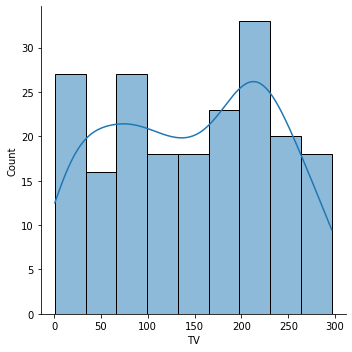

In [10]:
plt.figure(figsize=(10,7))
sns.displot(df['TV'],kde=True)

<Figure size 720x504 with 0 Axes>

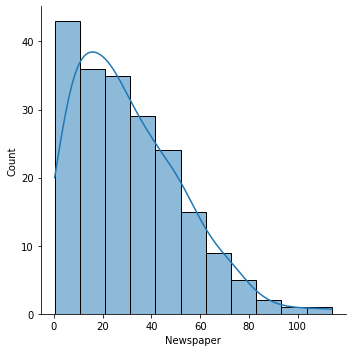

In [11]:
plt.figure(figsize=(10,7))
sns.displot(df['Newspaper'],kde=True)

<Figure size 720x504 with 0 Axes>

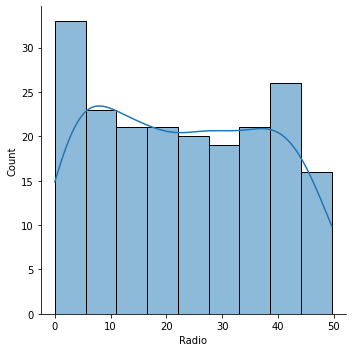

In [12]:
plt.figure(figsize=(10,7))
sns.displot(df['Radio'],kde=True)

<Figure size 720x504 with 0 Axes>

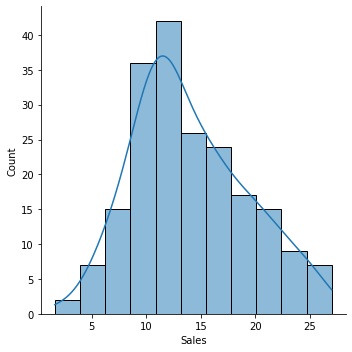

In [13]:
plt.figure(figsize=(10,7))
sns.displot(df['Sales'],kde=True)

<Axes: >

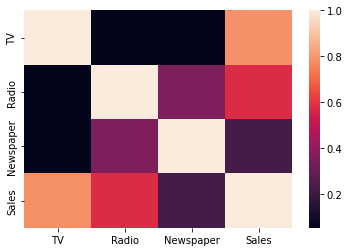

In [14]:
sns.heatmap(df.corr())

# **HANDLING OUTLIERS**

<Axes: >

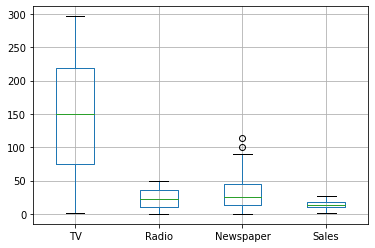

In [15]:
df.boxplot()

In [16]:
import pandas as pd

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

def detect_outliers(column):
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    if outliers.empty:
        return None, 0.0
    else:
        percentage = (len(outliers) / len(df)) * 100
        return column, percentage

numeric_columns = df.select_dtypes(include=['number']).columns
columns_with_outliers = [detect_outliers(column) for column in numeric_columns]
columns_with_outliers = [(column, percentage) for column, percentage in columns_with_outliers if column is not None]

for column, percentage in columns_with_outliers:
    print(f"Column: {column}, Percentage of outliers: {percentage:.2f}%")

Column: Newspaper, Percentage of outliers: 1.00%


In [17]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_range=Q1-1.5*IQR
    upper_range=Q3+1.5*IQR
    return lower_range,upper_range

In [18]:
low_leadtime,high_leadtime=remove_outlier(df['Newspaper'])
df['Newspaper']=np.where(df['Newspaper']>high_leadtime,high_leadtime,df['Newspaper'])
df['Newspaper']=np.where(df['Newspaper']<low_leadtime,low_leadtime,df['Newspaper'])

# **SPLITTING**

In [19]:
x=df.drop(['Sales'],axis=1)
y=df['Sales']

In [20]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=142)

In [21]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(160, 3)
(40, 3)
(160,)
(40,)


# **StandardScaler**

In [22]:
scalar=StandardScaler()
scalar.fit(xtrain)
xtrain_sc=scalar.transform(xtrain)
xtest_sc=scalar.transform(xtest)

# **MODELLING**

# LinearRegression

In [23]:
lr=LinearRegression()
lr.fit(xtrain_sc,ytrain)
ypred_train=lr.predict(xtrain_sc)
ypred_test=lr.predict(xtest_sc)

In [24]:
print(r2_score(ytrain,ypred_train))
print(r2_score(ytest,ypred_test)) 

0.8951262853783359
0.899912199858492


# RandomForestRegressor

In [25]:
rf=RandomForestRegressor(n_estimators=250,max_depth=25,min_samples_split=8,min_samples_leaf=2)
rf.fit(xtrain_sc,ytrain)
ypred_train_rf=rf.predict(xtrain_sc)
ypred_test_rf=rf.predict(xtest_sc)

In [26]:
print(r2_score(ytrain,ypred_train_rf))
print(r2_score(ytest,ypred_test_rf)) 

0.9904622378015473
0.9764146393008101


# XGBRegressor

In [27]:
XGBoost=xgb.XGBRegressor()            
XGBoost.fit(xtrain_sc,ytrain)
ypred_train_XGBoost = XGBoost.predict(xtrain_sc)
ypred_test_XGBoost = XGBoost.predict(xtest_sc)

In [28]:
print(r2_score(ytrain,ypred_train_XGBoost))
print(r2_score(ytest,ypred_test_XGBoost)) 

0.9999999242337473
0.9835750020989663


# Lasso

In [29]:
las=Lasso(alpha=0.6)
las.fit(xtrain_sc,ytrain)
ypred_train_las = las.predict(xtrain_sc)
ypred_test_las = las.predict(xtest_sc)

In [30]:
print(r2_score(ytrain,ypred_train_las))
print(r2_score(ytest,ypred_test_las)) 

0.8709131606481074
0.8683216243426591


# comparing accuracy

In [31]:
models = pd.DataFrame(
    {
        'Model' : ['LR', 'LR', 'RF', 'RF', 'XGB', 'XGB', 'LS', 'LS'],
        'Group' : [
            'train',
            'test',
            'train',
            'test', 
            'train',
            'test', 
            'train',
            'test'], 
        'Accuracy2' : [
             r2_score(ytrain, ypred_train)*100,
             r2_score(ytest, ypred_test)*100,
             r2_score(ytrain, ypred_train_rf)*100,
             r2_score(ytest, ypred_test_rf)*100,
             r2_score(ytrain, ypred_train_XGBoost)*100,
             r2_score(ytest, ypred_test_XGBoost)*100,
             r2_score(ytrain, ypred_train_las)*100,
             r2_score(ytest, ypred_test_las)*100,
        ]
    }
)

In [32]:
models

,Model,Group,Accuracy2
0,LR,train,89.512629
1,LR,test,89.991220
2,RF,train,99.046224
3,RF,test,97.641464
4,XGB,train,99.999992
5,XGB,test,98.357500
6,LS,train,87.091316
7,LS,test,86.832162


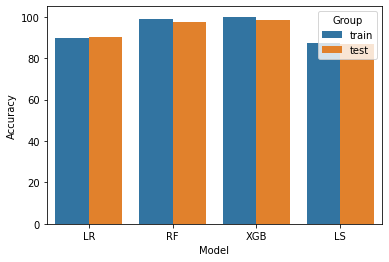

In [33]:
sns.barplot(
    x='Model',
    y='Accuracy2',
    hue='Group',
    data= models
)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# predictions on new data

In [34]:
new_data = pd.DataFrame({'TV': [25], 'Radio': [63], 'Newspaper': [80]})
predicted_sales = rf.predict(new_data)
print("Predicted Sales:", predicted_sales)

Predicted Sales: [24.97397971]
